# Why does plotting a RA,Dec grid fail for deepCoadds but not calexps?

Referring to the recommended RA,Dec overlay process of matplotlib + astropy WCS.

Fri Apr 29, data-int.lsst.cloud

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import pandas
pandas.set_option('display.max_rows', 1000)

import lsst.daf.butler as dafButler

import lsst.geom
import lsst.afw.display as afwDisplay
afwDisplay.setDefaultBackend('matplotlib')

from astropy.wcs import WCS
from astropy import units as u
from astropy.coordinates import SkyCoord

## Choose a deepCoadd image of a cluster that we are familiar with.

In [2]:
repo = 's3://butler-us-central1-panda-dev/dc2/butler-external.yaml'
collection = '2.2i/runs/DP0.2/v23_0_1_rc1/PREOPS-905/pilot_tract4431'

butler = dafButler.Butler(repo, collections=collection)

In [3]:
my_spherePoint = lsst.geom.SpherePoint(55.745834*lsst.geom.degrees,
                                       -32.269167*lsst.geom.degrees)
skymap = butler.get('skyMap')
my_tract = skymap.findTract(my_spherePoint)
my_patch = my_tract.findPatch(my_spherePoint)
my_patch_id = my_tract.getSequentialPatchIndex(my_patch)
dataId = {'band': 'i', 'tract': 4431, 'patch': 17}

In [4]:
deepCoadd        = butler.get('deepCoadd_calexp', dataId=dataId)
deepCoadd_bbox   = butler.get('deepCoadd_calexp.bbox', dataId=dataId)
deepCoadd_wcs    = butler.get('deepCoadd_calexp.wcs', dataId=dataId)
deepCoadd_fitsMd = WCS(deepCoadd_wcs.getFitsMetadata())

In [5]:
# print(deepCoadd_bbox)
# print(' ')
# print(deepCoadd_wcs)
# print(deepCoadd_fitsMd)

## Choose a calexp that we know should overlap with this deepCoadd

In [6]:
coadd_inputs = butler.get("deepCoadd_calexp.coaddInputs", dataId)
coadd_inputs_ccds_table = coadd_inputs.ccds.asAstropy()
use_detector = coadd_inputs_ccds_table['ccd'][0]
use_visit = coadd_inputs_ccds_table['visit'][0]
print(use_detector, use_visit)

0 227922


In [7]:
calexp        = butler.get('calexp', detector=use_detector, visit=use_visit)
calexp_bbox   = butler.get('calexp.bbox', detector=use_detector, visit=use_visit)
calexp_wcs    = butler.get('calexp.wcs', detector=use_detector, visit=use_visit)
calexp_fitsMd = WCS(calexp_wcs.getFitsMetadata())

## Get the corners and show they overlap

In [8]:
### corners go clockwise from lower left:
###  lower left, upper left, upper right, lower right
dc_crnrs = [ deepCoadd_wcs.pixelToSky(deepCoadd_bbox.beginX, deepCoadd_bbox.beginY), 
             deepCoadd_wcs.pixelToSky(deepCoadd_bbox.beginX, deepCoadd_bbox.endY), 
             deepCoadd_wcs.pixelToSky(deepCoadd_bbox.endX, deepCoadd_bbox.endY), 
             deepCoadd_wcs.pixelToSky(deepCoadd_bbox.endX, deepCoadd_bbox.beginY) ]

print('deepCoadd corners in hmsdms format:')
dc_crnrs_deg = np.zeros((4,2), dtype = 'float')
for i in range(4):
    dc_crnrs_deg[i,0] = dc_crnrs[i].getRa().asDegrees()
    dc_crnrs_deg[i,1] = dc_crnrs[i].getDec().asDegrees()
    coord = SkyCoord(ra = dc_crnrs[i].getRa().asDegrees()*u.degree, 
                     dec = dc_crnrs[i].getDec().asDegrees()*u.degree)
    ra = str(coord.to_string('hmsdms')).split()[0]
    dec = str(coord.to_string('hmsdms')).split()[1]
    print('%1i %10ss %11ss' % (i, ra[0:10], dec[0:11]))

ca_crnrs = [ calexp_wcs.pixelToSky(calexp_bbox.beginX, calexp_bbox.beginY), 
             calexp_wcs.pixelToSky(calexp_bbox.beginX, calexp_bbox.endY), 
             calexp_wcs.pixelToSky(calexp_bbox.endX, calexp_bbox.endY), 
             calexp_wcs.pixelToSky(calexp_bbox.endX, calexp_bbox.beginY) ]

print('calexp corners in hmsdms format:')
ca_crnrs_deg = np.zeros((4,2), dtype = 'float')
for i in range(4):
    ca_crnrs_deg[i,0] = ca_crnrs[i].getRa().asDegrees()
    ca_crnrs_deg[i,1] = ca_crnrs[i].getDec().asDegrees()
    coord = SkyCoord(ra = ca_crnrs[i].getRa().asDegrees()*u.degree, 
                     dec = ca_crnrs[i].getDec().asDegrees()*u.degree)
    ra = str(coord.to_string('hmsdms')).split()[0]
    dec = str(coord.to_string('hmsdms')).split()[1]
    print('%1i %10ss %11ss' % (i, ra[0:10], dec[0:11]))


deepCoadd corners in hmsdms format:
0 03h43m09.6s -32d19m20.0s
1 03h43m09.5s -32d05m20.0s
2 03h42m03.4s -32d05m20.0s
3 03h42m03.3s -32d19m20.0s
calexp corners in hmsdms format:
0 03h42m08.6s -32d19m17.7s
1 03h42m10.2s -32d06m00.5s
2 03h41m06.2s -32d05m41.6s
3 03h41m04.5s -32d18m58.9s


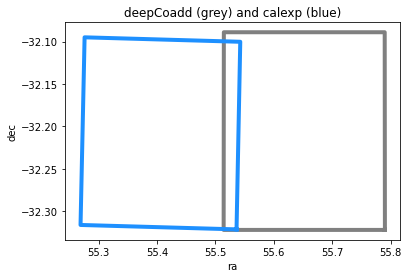

In [9]:
fig = plt.figure(figsize=(6,4))

plt.plot( [dc_crnrs_deg[0][0], dc_crnrs_deg[1][0], dc_crnrs_deg[2][0], dc_crnrs_deg[3][0], dc_crnrs_deg[0][0]], 
          [dc_crnrs_deg[0][1], dc_crnrs_deg[1][1], dc_crnrs_deg[2][1], dc_crnrs_deg[3][1], dc_crnrs_deg[0][1]],
          ls='solid', lw=4, alpha=1, color='grey' )
plt.plot( [ca_crnrs_deg[0][0], ca_crnrs_deg[1][0], ca_crnrs_deg[2][0], ca_crnrs_deg[3][0], ca_crnrs_deg[0][0]], 
          [ca_crnrs_deg[0][1], ca_crnrs_deg[1][1], ca_crnrs_deg[2][1], ca_crnrs_deg[3][1], ca_crnrs_deg[0][1]],
          ls='solid', lw=4, alpha=1, color='dodgerblue' )

plt.xlabel( 'ra' )
plt.ylabel( 'dec' )
# plt.xlim([np.min(crnrs_deg[:,0])-0.01, np.max(crnrs_deg[:,0])+0.01])
# plt.ylim([np.min(crnrs_deg[:,1])-0.01, np.max(crnrs_deg[:,1])+0.01])
plt.title( 'deepCoadd (grey) and calexp (blue)' )
plt.show()

## show that the RA,Dec grid is incorrect for the deepCoadd

For the deepCoadd, the RA,Dec projection grid does not match the corners from the bbox, printed below. The calexp's grid and corners do match. This calexp overlaps the deepCoadd (it is one of the results from: `coadd_inputs = butler.get("deepCoadd_calexp.coaddInputs", dataId)`).

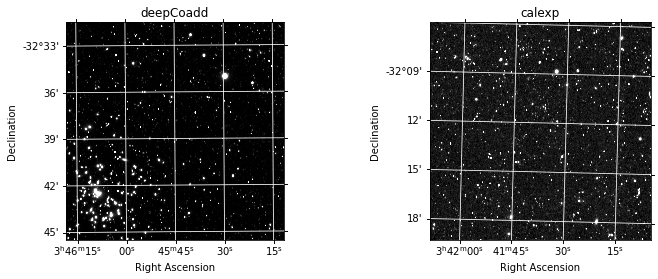

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4), sharex=False, sharey=False)

plt.subplot(1, 2, 1, projection=WCS(deepCoadd.getWcs().getFitsMetadata()))
plt.imshow(deepCoadd.image.array, cmap='gray', vmin=0, vmax=2, origin='lower')
plt.grid(color='white', ls='solid')
plt.xlabel('Right Ascension')
plt.ylabel('Declination')
plt.title('deepCoadd')

plt.subplot(1, 2, 2,  projection=WCS(calexp.getWcs().getFitsMetadata()))
plt.imshow(calexp.image.array, cmap='gray', vmin=-10, vmax=100, origin='lower')
plt.grid(color='white', ls='solid')
plt.xlabel('Right Ascension')
plt.ylabel('Declination')
plt.title('calexp')

plt.show()